### CO2 Emission Prediction.
Data can be obtained [here](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64).

In [152]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

In [153]:
df = pd.read_csv('data/co2_emission.csv')
df.head()

,model year,make,model,vehicle class,engine size (l),cylinders,transmission,fuel type,fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km),co2 rating,smog rating
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [154]:
print("Number of samples: %.0f" % df.shape[0])
print("Number of features: %.0f" % df.shape[1])

Number of samples: 5003
Number of features: 15


## Data Validation
### Missing Values
Let's begin by checking for missing values:

In [155]:
df.isnull().sum()

model year                          0
make                                0
model                               0
vehicle class                       0
engine size (l)                     0
cylinders                           0
transmission                        0
fuel type                           0
fuel consumption city (l/100 km)    0
fuel consumption hwy (l/100 km)     0
fuel consumption comb (l/100 km)    0
fuel consumption comb (mpg)         0
co2 emissions (g/km)                0
co2 rating                          0
smog rating                         0
dtype: int64

The dataset does not have any missing values.

Following the information on the website, the ``co2 rating`` and the ``smog rating`` features are ratings given to a car after the `co2 emission` is known. Thus, this information cannot be included in our model, as we would like to create a model capable of predicting the CO2 emission of a car based on its features. We are going to remove the ``co2 rating`` and the ``smog rating`` from our analysis.

In [156]:
del df['co2 rating']
del df['smog rating']

Now, let's look at the column types:

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   model year                        5003 non-null   int64  
 1   make                              5003 non-null   object 
 2   model                             5003 non-null   object 
 3   vehicle class                     5003 non-null   object 
 4   engine size (l)                   5003 non-null   float64
 5   cylinders                         5003 non-null   int64  
 6   transmission                      5003 non-null   object 
 7   fuel type                         5003 non-null   object 
 8   fuel consumption city (l/100 km)  5003 non-null   float64
 9   fuel consumption hwy (l/100 km)   5003 non-null   float64
 10  fuel consumption comb (l/100 km)  5003 non-null   float64
 11  fuel consumption comb (mpg)       5003 non-null   int64  
 12  co2 em

The `model year` and `cylinder` columns have the `int64` dtype. Let's look at its count of values:

In [158]:
df['model year'].value_counts()

2018    1083
2019    1056
2020     968
2022     955
2021     941
Name: model year, dtype: int64

In [159]:
df['cylinders'].value_counts()

4     2165
6     1594
8     1003
12     105
3       84
10      36
16       9
5        7
Name: cylinders, dtype: int64

This is actually a categorical column, as these years have discrete values. Let's change the column dtype:

In [160]:
df['model year'] = df['model year'].astype(str)
df['cylinders'] = df['cylinders'].astype(str)

In [161]:
cat_cols = list(df.loc[:, df.dtypes == object].columns)
num_cols = list(df.loc[:, df.dtypes != object].columns)

## Exploratory Data Analysis
Beforing exploring the data, we are going to split the data into train/test/validation sets, with a 60/20/20% ratio.

In [162]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

## Categorical features

Now, let's look at how many unique values the categorical columns have:

In [163]:
df_train_full[cat_cols].nunique()

model year          5
make               39
model            1326
vehicle class      15
cylinders           8
transmission       26
fuel type           4
dtype: int64

Let's analyze each feature individually.
### Model Year

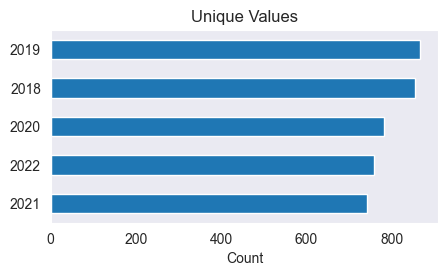

In [164]:
plt.figure(figsize=(5,2.5))
df_train_full['model year'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

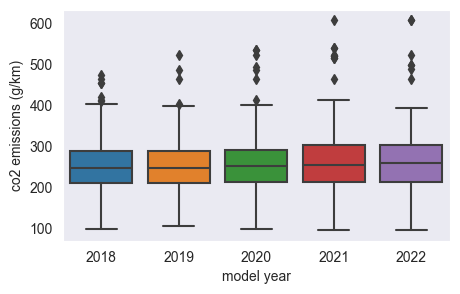

In [165]:
plt.figure(figsize=(5,3))
sns.boxplot(x='model year', 
            y='co2 emissions (g/km)', 
            data=df_train_full.sort_values(by='model year'))
plt.show()

We can see that the CO2 emission has sligthly increased ove the years (which is worrisome, by the way). 

#### Make
The make column contains information about the car manufacturer.

Unique values in the make column:  39


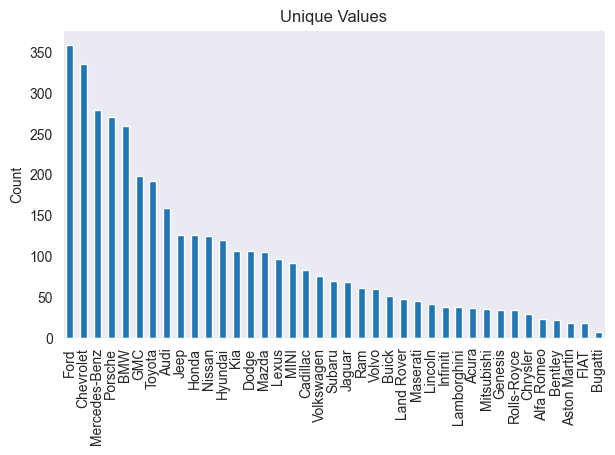

In [166]:
print("Unique values in the make column: ", df_train_full['make'].nunique())
plt.figure(figsize=(7,4))
df_train_full['make'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Unique Values')
plt.ylabel('Count')
plt.show()

Ford, Chevrolet, Mercedes-Benz, Porsche and BMW are the top 5 manufacturers. Manufacturer's of luxury cars, such as Lamborghini, Rolls-Royce and Bugatti, have very few samples.

Let's see how is the CO2 emission distribution among the manufacturers.

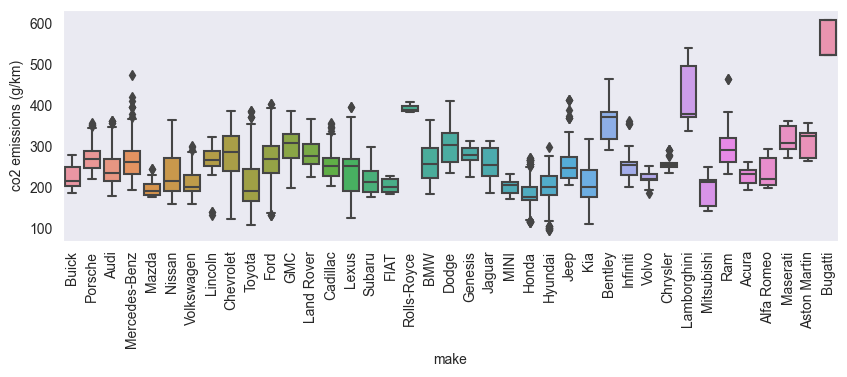

In [167]:
plt.figure(figsize=(10,3))
ax = sns.boxplot(x='make', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The manufacturers present very different distributions of co2 emission. This will be a important feature for our predictions.

Here we can observe some trends:
- Among the cars with the lowest emissions, we find Mazda, Nissan, Toyota, Subaru, Honda and Mitsubishi: all of them are japanese companies. 
- The highest emissions come from manufacturers that produce luxury cars: Rolls-Royce, Bentley, Lamborghini and Bugatti.

### Vehicle Class
Here we have information about the vehicle size (Small, mid-size, compact, etc) and its type (SUV, Pickup truck, van, etc).

Unique values in the vehicle class column:  15


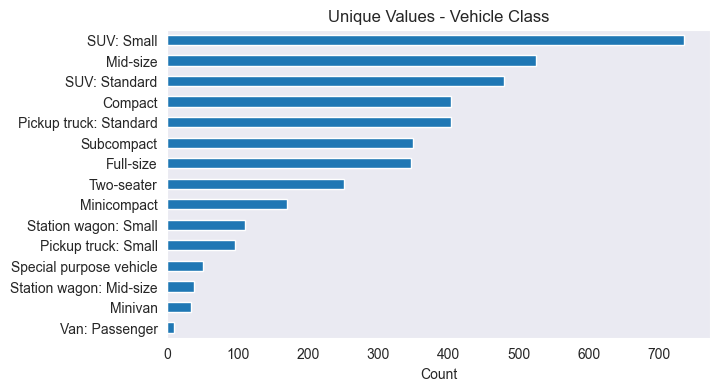

In [168]:
print("Unique values in the vehicle class column: ", df_train_full['vehicle class'].nunique())
plt.figure(figsize=(7,4))
df_train_full['vehicle class'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Vehicle Class')
plt.xlabel('Count')
plt.show()

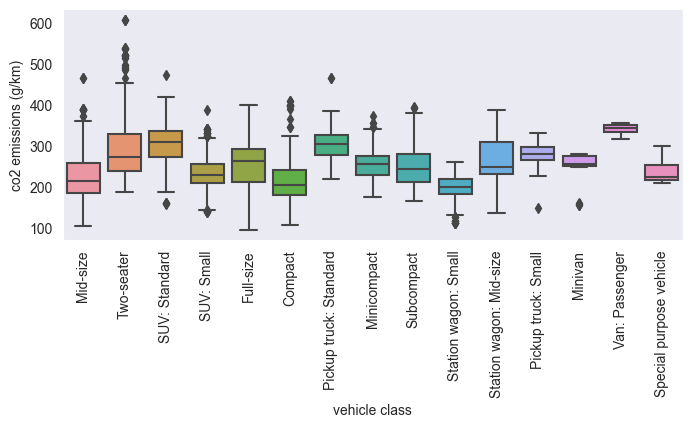

In [169]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='vehicle class', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The compact cars are among those that have the lowest C02 emission rates.

### Cylinders

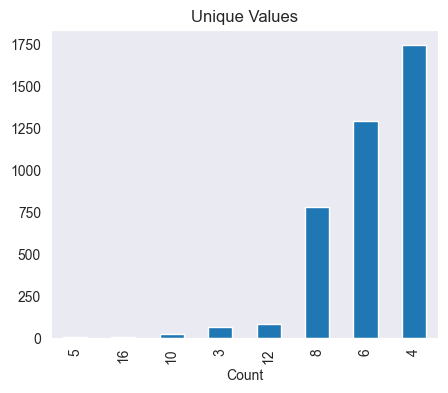

In [170]:
plt.figure(figsize=(5,4))
df_train_full['cylinders'].value_counts().sort_values().plot(kind='bar')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

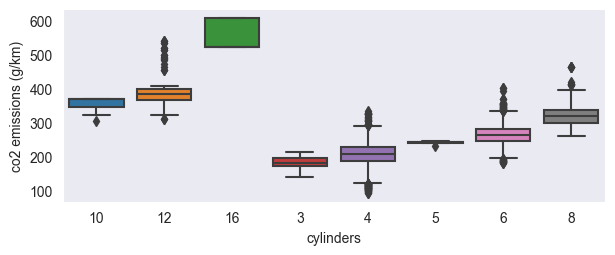

In [171]:
plt.figure(figsize=(7, 2.5))
ax = sns.boxplot(x='cylinders',
                 y='co2 emissions (g/km)', 
                 data=df_train_full.sort_values(by="cylinders"))
plt.show()

Clearly, the CO2 emission rating increases with the cylinders. Thus, this is a very important feature to the model.

### Fuel Type
The fuel type is classified as:

- D = diesel
- E = ethanol (E85)
- X = regular gasoline
- Z = premium gasoline

Unique values in the fuel type column:  4


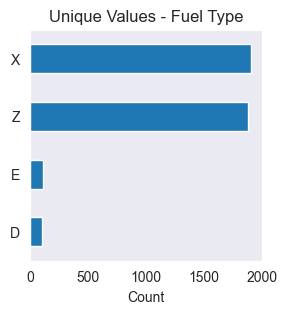

In [172]:
print("Unique values in the fuel type column: ", df_train_full['fuel type'].nunique())
plt.figure(figsize=(3,3))
df_train_full['fuel type'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Fuel Type')
plt.xlabel('Count')
plt.show()

Most of the cars run by gasoline, with a minority of the running by ethanol and diesel.

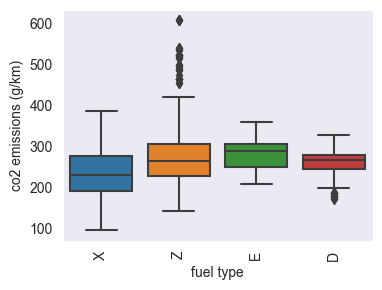

In [173]:
plt.figure(figsize=(4,3))
ax = sns.boxplot(x='fuel type', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Ethanol and diesel cars have consistently high CO2 emission rates, above 200 g/km for more than 95% of the cars. Cars that run by gasoline present some of the highest emission rates, but also some of the lowest.  

## Numerical Features
Now, let's look at the numerical features and their relations with the CO2 emission rating.

### Correlations
First, let's look at the correlations between the features.

In [174]:
num_cols

['engine size (l)',
 'fuel consumption city (l/100 km)',
 'fuel consumption hwy (l/100 km)',
 'fuel consumption comb (l/100 km)',
 'fuel consumption comb (mpg)',
 'co2 emissions (g/km)']

In [175]:
df_train_full[num_cols].corr()

,engine size (l),fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km)
engine size (l),1.000000,0.837142,0.757712,0.822162,-0.723847,0.833662
fuel consumption city (l/100 km),0.837142,1.000000,0.933221,0.992027,-0.911873,0.949557
fuel consumption hwy (l/100 km),0.757712,0.933221,1.000000,0.970715,-0.886318,0.916930
fuel consumption comb (l/100 km),0.822162,0.992027,0.970715,1.000000,-0.917156,0.952956
fuel consumption comb (mpg),-0.723847,-0.911873,-0.886318,-0.917156,1.000000,-0.906536
co2 emissions (g/km),0.833662,0.949557,0.916930,0.952956,-0.906536,1.000000


In [176]:
# sns.pairplot(df_train_full[['co2 emissions (g/km)', 'engine size (l)']], height=2)
# plt.show()

In [177]:
num_cols

['engine size (l)',
 'fuel consumption city (l/100 km)',
 'fuel consumption hwy (l/100 km)',
 'fuel consumption comb (l/100 km)',
 'fuel consumption comb (mpg)',
 'co2 emissions (g/km)']

### CO2 Emissions (g/km)

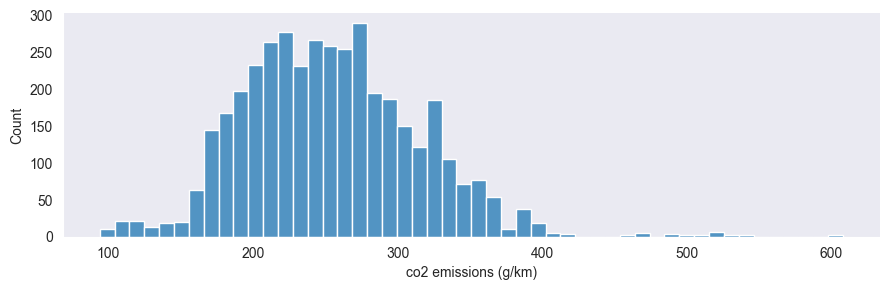

In [193]:
sns.displot(df_train_full['co2 emissions (g/km)'], kde=False, height=3, aspect=3)
plt.show()

### Engine Size (l)

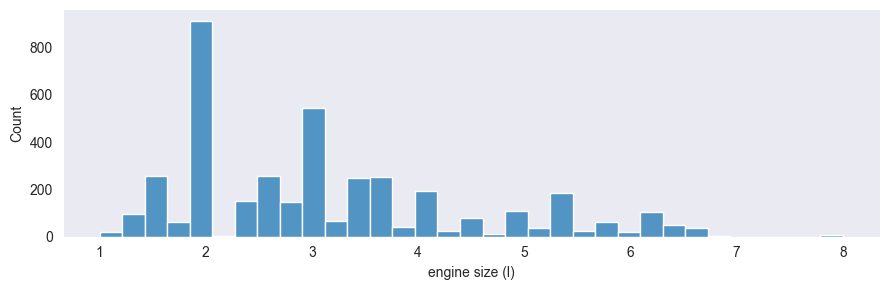

In [178]:
sns.displot(df_train_full['engine size (l)'], kde=False, height=3, aspect=3)
plt.show()

### Fuel Consumption - City (L/100 km)

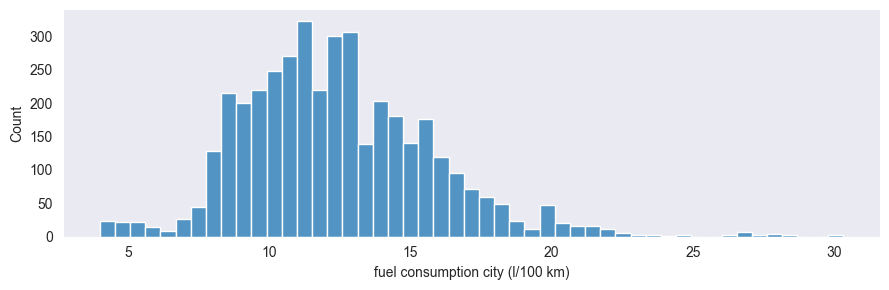

In [179]:
sns.displot(df_train_full['fuel consumption city (l/100 km)'], kde=False, height=3, aspect=3)
plt.show()

Data is normalized.

### Fuel Consumption - Highway (L/100 km)

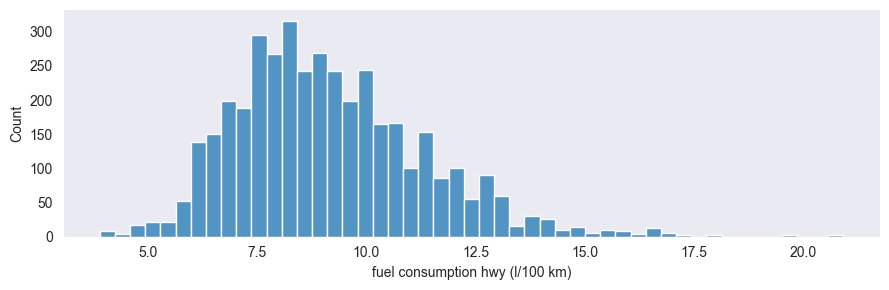

In [180]:
sns.displot(df_train_full['fuel consumption hwy (l/100 km)'], kde=False, height=3, aspect=3)
plt.show()

Data is normalized.

### Fuel Consumption - Combination (l/100 km)

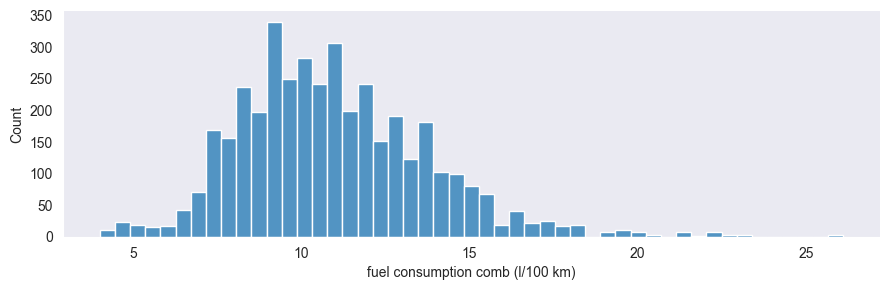

In [181]:
sns.displot(df_train_full['fuel consumption comb (l/100 km)'], kde=False, height=3, aspect=3)
plt.show()

### Fuel Consumption Comb (mpg)

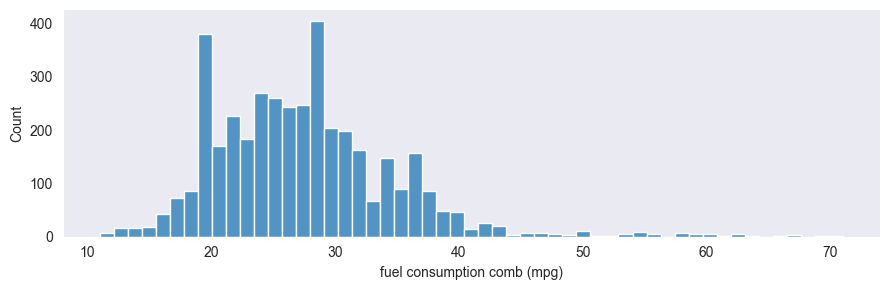

In [194]:
sns.displot(df_train_full['fuel consumption comb (mpg)'], kde=False, height=3, aspect=3)
plt.show()

In [186]:
# Creating target series
y_train = df_train['co2 emissions (g/km)']
y_val = df_val['co2 emissions (g/km)']

# Removing target from train sets
# X_train = df_train.drop(['co2 emissions (g/km)'], axis=1)
# X_val = df_val.drop(['co2 emissions (g/km)'], axis=1)
# X_train = df_train.drop(['co2 emissions (g/km)', 'model'], axis=1)
# X_val = df_val.drop(['co2 emissions (g/km)', 'model'], axis=1)
# X_train = df_train.drop(['co2 emissions (g/km)', 'fuel consumption comb (l/100 km)', 'fuel consumption comb (mpg)', 'model'], axis=1)
# X_val = df_val.drop(['co2 emissions (g/km)', 'fuel consumption comb (l/100 km)', 'fuel consumption comb (mpg)', 'model'], axis=1)
X_train = df_train.drop(['co2 emissions (g/km)', 'fuel consumption city (l/100 km)', 'fuel consumption hwy (l/100 km)', 'fuel consumption comb (mpg)', 'model'], axis=1)
X_val = df_val.drop(['co2 emissions (g/km)', 'fuel consumption city (l/100 km)', 'fuel consumption hwy (l/100 km)', 'fuel consumption comb (mpg)', 'model'], axis=1)

X_cat_cols = list(X_train.loc[:, df.dtypes == object].columns)
X_num_cols = list(X_train.loc[:, df.dtypes != object].columns)

In [187]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def make_pipeline(model):
    """Create a pipeline for a model."""

    cat_transf = OneHotEncoder(sparse=False,
                               handle_unknown="ignore")

    std_scaler = StandardScaler()

    transformer = ColumnTransformer(transformers=[("cat", cat_transf, X_cat_cols),
                                                   ("num_scaler", std_scaler, X_num_cols)],
                                    remainder='passthrough'
                                   )

    steps = [("transformer", transformer),
             ("model", model)]
    
    return Pipeline(steps)

In [188]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lrg = LinearRegression()

pipe_lrg = make_pipeline(lrg) 

pipe_lrg.fit(X_train, y_train)

y_pred_train = pipe_lrg.predict(X_train)
y_pred_val = pipe_lrg.predict(X_val)

lrg_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
lrg_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(lrg_score_train))
print("RMSE Validation = {:0.3f}".format(lrg_score_val))

RMSE Train = 2.851
RMSE Validation = 21793166065.377


In [189]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfr = RandomForestRegressor()

pipe_rfr = make_pipeline(rfr)

pipe_rfr.fit(X_train, y_train)

y_pred_train = pipe_rfr.predict(X_train)
y_pred_val = pipe_rfr.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(rfr_score_train))
print("RMSE Validation = {:0.3f}".format(rfr_score_val))

RMSE Train = 1.254
RMSE Validation = 2.812


### Test Data

In [36]:
y_train_full = df_train_full['co2 emissions (g/km)']
y_test = df_test['co2 emissions (g/km)']

X_train_full = df_train_full[X_cat_cols + X_num_cols]
X_test = df_test[X_cat_cols + X_num_cols]

In [38]:
pipe_rfr.fit(X_train_full, y_train_full)

y_pred_train_full = pipe_rfr.predict(X_train_full)
y_pred_test = pipe_rfr.predict(X_test)

rfr_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rfr_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE Train = {:0.3f}".format(rfr_score_train_full))
print("RMSE Test = {:0.3f}".format(rfr_score_test))

RMSE Train = 0.839
RMSE Test = 1.654


In [ ]:
stopper

In [ ]:
rmses = []
for n in range(10, 201, 10):

    rfr = RandomForestRegressor(n_estimators=n, random_state=3)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%3s -> %.3f' % (n, rmse))

    rmses.append(rmse)

 10 -> 3.201
 20 -> 3.506
 30 -> 3.192
 40 -> 3.246
 50 -> 3.195
 60 -> 3.065
 70 -> 3.018
 80 -> 3.075
 90 -> 3.075
100 -> 3.043
110 -> 3.076
120 -> 3.040
130 -> 3.011
140 -> 3.008
150 -> 2.993
160 -> 3.005
170 -> 2.996
180 -> 3.009
190 -> 3.018
200 -> 3.004


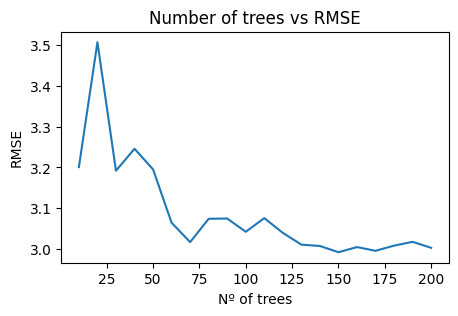

In [ ]:
num_trees = range(10, 201, 10)

plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses)
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.title('Number of trees vs RMSE')
plt.show()

In [ ]:
all_rmses_depth = {}

for depth in [5, 10, 20]:
    print('max_depth: %s' % depth)

    rmses = []
    for trees in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=trees, 
                                    max_depth=depth, 
                                    random_state=3)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_depth[depth] = rmses

max_depth: 5
 10 -> 10.183
 20 -> 10.125
 30 -> 10.347
 40 -> 9.588
 50 -> 9.425
 60 -> 9.374
 70 -> 9.329
 80 -> 9.446
 90 -> 9.310
100 -> 9.346
110 -> 9.193
120 -> 9.036
130 -> 9.151
140 -> 9.108
150 -> 9.005
160 -> 9.053
170 -> 9.027
180 -> 9.145
190 -> 9.312
200 -> 9.270

max_depth: 10
 10 -> 5.429
 20 -> 5.555
 30 -> 5.966
 40 -> 5.770
 50 -> 6.133
 60 -> 6.421
 70 -> 6.731
 80 -> 6.844
 90 -> 6.927
100 -> 6.857
110 -> 6.781
120 -> 6.823
130 -> 6.839
140 -> 6.875
150 -> 6.872
160 -> 6.919
170 -> 7.075
180 -> 7.117
190 -> 7.214
200 -> 7.249

max_depth: 20
 10 -> 8.706
 20 -> 7.698
 30 -> 7.686
 40 -> 7.509
 50 -> 7.459
 60 -> 7.507
 70 -> 7.579
 80 -> 7.745
 90 -> 7.968
100 -> 7.765
110 -> 7.834
120 -> 7.602
130 -> 7.548
140 -> 7.542
150 -> 7.554
160 -> 7.675
170 -> 7.543
180 -> 7.555
190 -> 7.603
200 -> 7.590



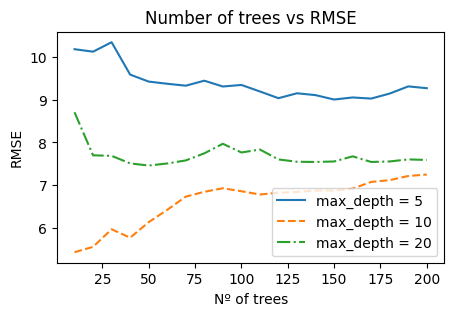

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_rmses_depth[5], '-', label='max_depth = 5')
plt.plot(num_trees, all_rmses_depth[10], '--', label='max_depth = 10')
plt.plot(num_trees, all_rmses_depth[20], '-.', label='max_depth = 20')
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.legend()
plt.title('Number of trees vs RMSE')
plt.show()

In [ ]:
all_rmses_leaf = {}

for samples in [3, 5, 10]:
    print('min_samples_leaf: %s' % samples)

    rmses = []
    for trees in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=trees,
                                     max_depth=10, 
                                     min_samples_leaf=samples, 
                                     random_state=3)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_leaf[samples] = rmses

min_samples_leaf: 3
 10 -> 9.042
 20 -> 8.048
 30 -> 8.312
 40 -> 8.335
 50 -> 8.018
 60 -> 8.288
 70 -> 8.277
 80 -> 8.323
 90 -> 8.595
100 -> 8.558
110 -> 8.344
120 -> 8.373
130 -> 8.397
140 -> 8.284
150 -> 8.304
160 -> 8.405
170 -> 8.483
180 -> 8.505
190 -> 8.610
200 -> 8.635

min_samples_leaf: 5
 10 -> 8.511
 20 -> 8.173
 30 -> 8.535
 40 -> 9.270
 50 -> 9.248
 60 -> 8.969
 70 -> 8.796
 80 -> 8.586
 90 -> 8.649
100 -> 8.653
110 -> 8.703
120 -> 8.663
130 -> 8.607
140 -> 8.515
150 -> 8.480
160 -> 8.480
170 -> 8.416
180 -> 8.573
190 -> 8.533
200 -> 8.626

min_samples_leaf: 10
 10 -> 9.820
 20 -> 10.140
 30 -> 9.474
 40 -> 9.106
 50 -> 8.986
 60 -> 9.137
 70 -> 9.103
 80 -> 9.208
 90 -> 9.161
100 -> 9.188
110 -> 9.200
120 -> 9.105
130 -> 9.106
140 -> 9.087
150 -> 9.069
160 -> 9.139
170 -> 9.145
180 -> 9.178
190 -> 9.249
200 -> 9.364



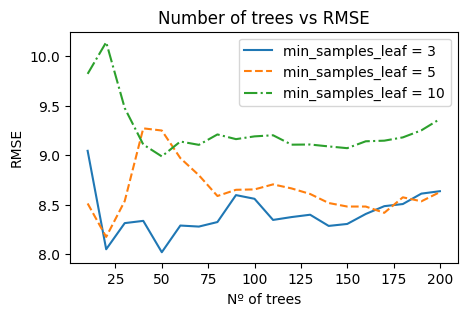

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_rmses_leaf[3], '-', label='min_samples_leaf = 3')
plt.plot(num_trees, all_rmses_leaf[5], '--', label='min_samples_leaf = 5')
plt.plot(num_trees, all_rmses_leaf[10], '-.', label='min_samples_leaf = 10')
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.legend()
plt.title('Number of trees vs RMSE')
plt.show()

In [ ]:
rfr_final = RandomForestRegressor(n_estimators=50, 
                                  max_depth=10, 
                                  min_samples_leaf=3,
                                  random_state=3)

rfr_final.fit(X_train, y_train)

y_pred_train = rfr_final.predict(X_train)
y_pred_val = rfr_final.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("ROC AUC Train = {:0.3f}".format(rfr_score_train))
print("ROC AUC Validation = {:0.3f}".format(rfr_score_val))

ROC AUC Train = 5.334
ROC AUC Validation = 8.018
